Workshop on IoT Networking - Data Analysis Track  - Version 0.9.5

Network Traffic Analysis Using Python/Jupyter

Guilherme G. Martins - gmartins uchicago edu 2020

In this workshop, we'll explore the Internet of Thing from the IP/TCP networking (Internet Protocol / Transmission Control Protocol) perspective. We'll use Wireshark, Jupyter Notebook and a local (IoT Lab) API to gather relevant information about the connected devices. Precisely, we want to visualize in a world map the TCP connection end-point locations as well as volume of sent and received data over time. We are first using a .pcap (packet capture file) collected from a smart camera installed inside the lab. After the that, the same steps can be used to analyze a .pcap file collected from your laptop accessing your favorite web site.

Other tracks: 
- IoT Networking - Data Collection - Using Single Board Computers to Collect and Monitor your Network Traffic. (TBD)
- IoT Survey on open source components and IoT building blocks. (TBD)

Requisites:
- Mac/Windows/Linux OS with terminal
- Python3/jupyter notebook/virtualenv+pip (https://jupyter.org/install)
- Wireshark Application (https://www.wireshark.org/#download)
- *bash* and *wget* via terminal
- IoTLab's geoip API (Use it inside the IoT Lab, network 192.168.XXX.0/24)

Motivation:

It is no secret that the proliferation of connected devices is imposing challenges from security and privacy standpoints. Your home network used to be a safe place with a handful of very well known devices. Now, it's even hard to keep track of the total number of connected devices: temperature sensors, cameras, smart toys, refrigerators, just to name a few. Multiple technologies are used to enable these devices to communicate and to interact with each other: Bluetooth, Zigbee, Near Field Communication (NFC) are just examples of communication protocols. But when it comes to using the full set of features provided by your IoT application, in most cases, it is required an internet connection to allow the IoT sending and receiving data to the cloud, potentially compromising security and privacy. Beyond just hoping that the IoT designers and operators are doing the right thing keeping both backend and IoT software secure, there are a few concepts, tools and techniques that we can be used to expose how these devices operate. The goal of this exercise is to explore some of these techniques.

By the end of this exercise you should be able to learn:
- How to decode a network traffic capture file (pcap) into csv (comma separated values);
- How to identify network packets from a specific devices in your network;
- How to visualize the TCP/UDP endpoints for all the external established connections;
- How to correlate activities and interaction with the IoT devices with a volume of sent and received data;  

References:

https://en.wikipedia.org/wiki/Ethernet_frame <br />
https://en.wikipedia.org/wiki/MAC_address <br />
https://en.wikipedia.org/wiki/IPv4 <br />
https://en.wikipedia.org/wiki/Internet_Protocol <br />
https://en.wikipedia.org/wiki/Transmission_Control_Protocol <br />
<Insert new Nick's book title here>

### 1. Testing Requirements

In [10]:
# we'll be using bash to run wget, tshark and other commands
!/bin/bash --version

GNU bash, version 3.2.57(1)-release (x86_64-apple-darwin19)
Copyright (C) 2007 Free Software Foundation, Inc.


In [11]:
# use wget to easily download the datasets and files from jupyter
!wget --version

GNU Wget 1.20.3 built on darwin19.0.0.

-cares +digest -gpgme +https +ipv6 +iri +large-file -metalink +nls 
+ntlm +opie -psl +ssl/openssl 

Wgetrc: 
    /usr/local/etc/wgetrc (system)
Locale: 
    /usr/local/Cellar/wget/1.20.3_2/share/locale 
Compile: 
    clang -DHAVE_CONFIG_H -DSYSTEM_WGETRC="/usr/local/etc/wgetrc" 
    -DLOCALEDIR="/usr/local/Cellar/wget/1.20.3_2/share/locale" -I. 
    -I../lib -I../lib -I/usr/local/opt/openssl@1.1/include -DNDEBUG -g 
    -O2 
Link: 
    clang -DNDEBUG -g -O2 -lidn2 -L/usr/local/opt/openssl@1.1/lib -lssl 
    -lcrypto -ldl -lz ftp-opie.o openssl.o http-ntlm.o ../lib/libgnu.a 
    -liconv -lintl -Wl,-framework -Wl,CoreFoundation -lunistring 

Copyright (C) 2015 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later
<http://www.gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Originally written by Hrvoje Niksic <hniksic@xemacs.org>.

In [12]:
# Make sure the terminal command 'tshark' is in your PATH environment variable and ready to be used.
# We'll use tshark to extract .csv data from the .pcap (packet capture format) to we can generate analysis

# Setting the path maybe required for systems like Mac or Windows 

path=%env PATH
%env PATH=$path:/Applications/Wireshark.app/Contents/MacOS/ 

!tshark --version

env: PATH=/Users/gmartins/chicago-cdac/iotlab/gmartins/devops/venv/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Users/gmartins/golang/go1.13.1/go/bin/:/Applications//Visual Studio Code.app/Contents/Resources/app/bin/:/Users/gmartins/.local/bin/:/Users/gmartins/Library/Python/3.7/bin/:/Applications/Wireshark.app/Contents/MacOS/:/Applications/Wireshark.app/Contents/MacOS/:/Applications/Wireshark.app/Contents/MacOS/
TShark (Wireshark) 3.0.7 (v3.0.7-0-g9435717b91f5)

Copyright 1998-2019 Gerald Combs <gerald@wireshark.org> and contributors.
License GPLv2+: GNU GPL version 2 or later <http://www.gnu.org/licenses/old-licenses/gpl-2.0.html>
This is free software; see the source for copying conditions. There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Compiled (64-bit) with libpcap, without POSIX capabilities, with GLib 2.37.6,
with zlib 1.2.11, with SMI 0.4.8, with c-ares 1.15.0, with Lua 5.2.4, with
GnuTLS 3.4.17, with Gcrypt 1.7.7, with MIT Kerbero

### 2. Downloading and Preparing the Data

In [13]:
# For analysing IoT device traffic you need to link information from multiple sources.
# The very first stop is to look at the MAC addresses and translate the first 3 octets 
# into the manufactor ID.
# The mac address resolution can be seen using the field (eth.dst_resolved and
# eth.src_resolved) while extracting csv from pcap (or even enabling mac address 
# resolution if you use the Wireshark GUI), but here we'll understand how to 
# link this information from a reliable source without relying on an
# external application.
# https://en.wikipedia.org/wiki/MAC_address
# https://en.wikipedia.org/wiki/Organizationally_unique_identifier
ouiurl="http://standards-oui.ieee.org/oui/oui.txt" 
#ouiurl="https://linuxnet.ca/ieee/oui.txt" #sanitized version of oui dataset
!if [ ! -f 'oui.txt' ]; then wget $ouiurl; else echo "INFO: file present"; fi

INFO: file present


In [14]:
##
# The packet capture file (.pcap) is the collection of all network packets
# sent and received by the iot device. It's not restricted to the IoT,
# in fact, you can collect packets while logging in to your facebook
# account for example. In that case, the pcap will contains your password,
# mostly likely encrypted and hashed. WARNING: Do not upload or share a
# pcap file of unless you are 100% sure you know what it's inside the file

##
# you can change the the name of the file here to work with one collected
# using the Wireshark program.
logfile = "camera4.pcap.log"
pcapfile = "camera4.pcap"
iotlaburl = "http://192.168.143.1/" #don't forget the "/" at the end

In [15]:
##
# let's work with a sample pcap file for now
# later your will use Wireshark to capture traffic from your station

pcapurl = iotlaburl+"iotlab/pcapsample/"+pcapfile # 3 days of packet capture
!if [ ! -f $pcapfile ]; then wget $pcapurl; else echo "INFO: file present"; fi

INFO: file present


In [16]:
#logurl = iotlaburl+"iotlab/pcapsample/"+logfile # 3 days of packet capture
#!if [ ! -f $logfile ]; then wget $logurl; else echo "INFO: file present"; fi

In [17]:
##
# We have a log file accompanying the some of our 
# pcap files. The log file should contain information
# about the time that the interactions took place
# for each IoT device
# eg. : cat camera4.pcap.log 
# 
#- 3:24pm start capture (-s 0)
#- 3:24pm power on camera
#- 3:26pm started streaming
#- 3:26pm stopped streaming
#- 3:27pm motion detection notification received (android phone)
#- 3:29pm start streaming
#- 3:29pm stopped streming
#- 3:30pm end capture

#!cat $logfile

In [18]:
!tail -n 20 oui.txt

In [19]:
##
# If you have any trouble importing pandas or any other package
# there are a few things you can do, one is to install conda or virtualenv
# 
# UNCOMMENT and run below to install the dependancies using virtualenv:

#!pip3 install virtualenv # install virtual environment
#!virtualenv venv # create venv folder to hold all the packages
#!source venv/bin/activate; pip3 install -r requirements.txt #<--- all the dependencies for this notebook
import sys
sys.path.append("venv/lib/python3.7/site-packages")

import re
import pandas as pd
import requests
from urllib.parse import urljoin

In [20]:
##
# This function will parse the oui file and make it available in
# a dataframe format. 

def generate_oui_dataframe():
    with open('oui.txt','r') as f:
        ouilines = f.readlines()
        p = re.compile("^(..-..-..).*\t\t(.*)") # Extract mac prefix 44-4A-DB and Manufacturer 
        macoui=[] # Organizational Unique Identifier OUI eg 44:4a:db
        macman=[] # manufacturer eg "Apple, Inc."
        for line in ouilines:
            r = p.match(line)
            if r is not None:
                try:
                    r1=r.group(1).replace("-",":").lower()
                    r2=r.group(2)
                except IndexError as ie:
                    print("WARN: generate_oui_dataframe regex - " + str(ie))
                    continue
                macoui.append(r1)
                macman.append(r2)
        df=pd.DataFrame({'macoui':macoui, 'macman':macman})
    return df

ouidf=generate_oui_dataframe()
ouidf

,macoui,macman
0,00:22:72,American Micro-Fuel Device Corp.
1,00:d0:ef,IGT
2,08:61:95,Rockwell Automation
3,f4:bd:9e,"Cisco Systems, Inc"
4,58:85:e9,Realme Chongqing MobileTelecommunications Corp...
...,...,...
27432,40:2e:71,Texas Instruments
27433,70:76:dd,OxyGuard Internation A/S
27434,64:bc:58,Intel Corporate
27435,28:e3:4e,"HUAWEI TECHNOLOGIES CO.,LTD"


In [21]:
##
# We will be looking mostly over tcp / udp connections.
# 
# Keep in mind that data can travel encapsulated or crafted
# inside various protocol/packet breaches. We commonly rely on
# standard IPS/IDS signatures for detecting cases where the
# data is traveling in uncommon ways (anomalies).
# Common IDS/IPS systems are Snort, Suricata and Bro.
#
# please note that the csv can expand 2x or 3x the size of
# the original pcap

!tshark -r $pcapfile -T fields -e frame.number -e frame.time \
-e frame.time_delta -e frame.time_relative -e eth.src_resolved  \
-e eth.dst_resolved -e eth.src -e eth.dst -e eth.type -e ip.version \
-e ip.hdr_len -e ip.len -e ip.id -e ip.flags.df -e ip.flags.mf \
-e ip.flags.rb -e ip.flags.sf -e ip.dsfield.dscp -e ip.dsfield.ecn \
-e ip.tos -e ip.ttl -e ip.proto -e ip.src -e ip.dst -e udp.srcport \
-e udp.dstport -e udp.length -e tcp.flags.cwr -e tcp.flags.ecn \
-e tcp.flags.urg -e tcp.flags.ack -e tcp.flags.push -e tcp.flags.reset \
-e tcp.flags.syn -e tcp.flags.fin -e tcp.flags.res -e tcp.flags.ns \
-e tcp.payload -e udp[] -e tcp.len -e frame.len -E header=y -E separator=\| > pcapfile.csv #  -e udp.payload?

In [22]:
dfpcap1 = pd.read_csv("pcapfile.csv", delimiter="|")
dfpcap1.head()

,frame.number,frame.time,frame.time_delta,frame.time_relative,eth.src_resolved,eth.dst_resolved,eth.src,eth.dst,eth.type,ip.version,...,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.flags.res,tcp.flags.ns,tcp.payload,tcp.len,frame.len
0,1,"Jan 17, 2020 15:25:14.592959000 CST",0.000000,0.000000,SamsungE_c2:38:2d,Broadcast,00:16:6c:c2:38:2d,ff:ff:ff:ff:ff:ff,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
1,2,"Jan 17, 2020 15:25:14.955789000 CST",0.362830,0.362830,SamsungE_c2:38:2d,Broadcast,00:16:6c:c2:38:2d,ff:ff:ff:ff:ff:ff,0x00000800,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322
2,3,"Jan 17, 2020 15:25:15.957152000 CST",1.001363,1.364193,Raspberr_37:d1:e2,SamsungE_c2:38:2d,dc:a6:32:37:d1:e2,00:16:6c:c2:38:2d,0x00000800,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342
3,4,"Jan 17, 2020 15:25:15.981141000 CST",0.023989,1.388182,SamsungE_c2:38:2d,Broadcast,00:16:6c:c2:38:2d,ff:ff:ff:ff:ff:ff,0x00000800,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334
4,5,"Jan 17, 2020 15:25:15.994385000 CST",0.013244,1.401426,Raspberr_37:d1:e2,SamsungE_c2:38:2d,dc:a6:32:37:d1:e2,00:16:6c:c2:38:2d,0x00000800,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342


In [23]:
###
# based on each TCP connection, there's an association
# between your local device and an external ip address.
# ip_mac will hold that mapping to use later on
ip_mac=dfpcap1[['ip.dst','eth.src']].drop_duplicates()
ouieth=[]
ouiman=[]
for index, row in ip_mac.iterrows():
    ouiman.append(ouidf[ouidf['macoui']==row['eth.src'][:8]]['macman'].iloc[0])
ip_mac['ouiman']=ouiman
ip_mac.head(10)

,ip.dst,eth.src,ouiman
0,NaN,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
1,255.255.255.255,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
2,192.168.144.25,dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd
7,224.0.0.22,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
9,NaN,dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd
10,192.168.144.1,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
11,"192.168.144.25,192.168.144.1",dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd
12,224.0.0.251,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
18,8.8.8.8,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
26,208.75.88.4,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"


In [24]:
# We want to say, for example:
# my Apple device (a4:83:8e7) connected to an ip address
# in ireland while I was interacting with it.
# The ip address is managed by a known XYZs ISP or CDN.

###
# count frames (packets) for each internet connection destination (end-point)
# rename the ip.src for ip.dst, this is a small hack to allow as to join dfs.
ip_dir='ip.dst' # ip.dst == upload direction, for download use ip.src
frames_per_dest=dfpcap1.loc[~dfpcap1[ip_dir].str.startswith('192.168.', na=False)].\
    groupby(ip_dir)['frame.number'].nunique().reset_index().rename(columns={'ip.src':'ip.dst'})
#frames_per_dest.head(10)

##
# join with ip_mac to see which device is the local IoT Endpoint
# we want to know the exact ouiman (eg, Apple, Inc.) Involved in the
# connection
connection=frames_per_dest.set_index('ip.dst').join(ip_mac.set_index('ip.dst')).\
    sort_values(by=['frame.number'], ascending=False).reset_index()
top5loc=connection.head(5) #we are only processing the top talkers here
top5loc                    #ideally we want to account for all of the connections

,ip.dst,frame.number,eth.src,ouiman
0,3.215.71.47,2514,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
1,52.9.179.227,120,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
2,128.135.11.14,38,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
3,8.8.8.8,15,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
4,224.0.0.251,14,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"


In [25]:
##
# We will use the IoT Lab API to help with geoip mapping
# run this cell connected to the IoT Lab Wifi
# this should print "OK" meaning that our local API is up and running
r = requests.request("GET", iotlaburl)
r.text

'OK'


##### At this point you should be able to have all the data in the right format (dataframe) to start visualizing some interesting graphics.
- oui dataset
- pcap file
- local API access
- connection list with merged data from oui 


### 3. Plotting TCP/UDP End-points Using Geo Location of IP addresses

Usually, geoip locations can provide a very good source of information
to help investigate the source and destination of IoT communications.
We're going to use a wrapper API around MaxMind GeoIP Dataset. It's not
100% accurate in terms of finding the exact location, but it's
reliable when it comes to find the organizations behind the management
of these IP destinations. For more information: https://www.maxmind.com/en/geoip-demo

In [26]:
###
# If you have any trouble importing the libraries below
# uncomment and run this block of commands. 
# A different path may be required for windows.

#!pip3 install virtualenv # install virtual environment
#!virtualenv venv # create venv folder to hold all the packages
#!source venv/bin/activate; pip3 install -r requirements.txt #<--- all the dependencies for this notebook
#import sys
#sys.path.append("venv/lib/python3.7/site-packages")

from bokeh.io import output_file, show, save
from bokeh.models import GeoJSONDataSource
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource, HoverTool
import json
from IPython.display import IFrame
import math

In [27]:
###
# This should take some serious time if pcap is larger than 200MB - be prepared.
# 
# What to expect: known names in the ISP, like google, amazon, fastly
# Not all ips have a clear location, sometimes CDNs provide ip collocation
# to make content delivery accessible at the edge with low latency.
# In that case, MaxMind may return records with empty city strings

isp = []
city = []
country = []
lat = []
lng = []
continent = []
color = []
for index, row in connection.iterrows():
    url=urljoin(iotlaburl+"/geoip/", row['ip.dst'])
    r = requests.request("GET", url)
    j = r.json()
    try:
        if j['error'] is not None:
            print(str(j)+" resolving "+row['ip.dst'])
            isp.append('')
            city.append('')
            country.append('')
            lat.append(0.0)
            lng.append(0.0)
            continent.append('')
            color.append('green')
            continue
    except KeyError as ke:
        pass
    
    isp.append(j['isp'])
    city.append(j['city'])
    country.append(j['country'])
    lat.append(float(j['lat']))
    lng.append(float(j['lng']))
    continent.append(j['continent'])
    color.append('green') # TODO: anomaly detection here, mark red
    #print(r.json())
connection['isp']=isp
connection['city']=city
connection['country']=country
connection['lat']=lat
connection['lng']=lng
connection['continent']=continent
connection['color']=color
connection.head(5)

{'error': 'unable to query API'} resolving 224.0.0.251
{'error': 'unable to query API'} resolving 224.0.0.22
{'error': 'unable to query API'} resolving 255.255.255.255


,ip.dst,frame.number,eth.src,ouiman,isp,city,country,lat,lng,continent,color
0,3.215.71.47,2514,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd",Amazon.com,Ashburn,US,39.0481,-77.4728,North America,green
1,52.9.179.227,120,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd",Amazon.com,San Jose,US,37.3388,-121.8914,North America,green
2,128.135.11.14,38,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd",University of Chicago,Chicago,US,41.7821,-87.6046,North America,green
3,8.8.8.8,15,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd",Google,Dallas,US,32.7889,-96.8021,North America,green
4,224.0.0.251,14,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd",,,,0.0000,0.0000,,green


In [28]:
#lift from
#https://towardsdatascience.com/
#exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10
def merc(Coords, origin):

    if Coords is None:
        return (0,0) 

    lat = Coords['lat']
    lng = Coords['lng']
  
    if (lat == 0.0 and lng == 0.0):
        if origin:
            lat = origin['lat']
            lng = origin['lng']
        else:
            return (0, 0)

    r_major = 6378137.000
    x = r_major * math.radians(lng)
    scale = x/lng
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [29]:
# Where are you now? (this is optional, just to plot some cool lines)
origin = {'lat':41.795,'lng':-87.60} #Chicago, Hyde Park, US
#origin = None

In [30]:
coords = dict( #coordinates for hover tool
    xs = [],
    ys = [],
    x = [],
    y = [],
    isp = [],
    oui = [],
    color = [],
)
for index, row in connection.iterrows():
    d=row.to_dict()
    o=merc(origin, origin)
    c=merc(d, origin)
    d['xs']=c[0]
    d['ys']=c[1]
    coords['xs'].append([o[0], c[0]]) #line for multiline plot
    coords['ys'].append([o[1], c[1]]) #line for multiline plot
    coords['x'].append(c[0])
    coords['y'].append(c[1])
    coords['isp'].append(d['isp'])
    coords['oui'].append(d['ouiman'])
    coords['color'].append("green") # TODO: Mark "red" anomalies / suspicious connections

In [31]:
def map_plot(coords, origin = None, title = None):
    """Plot multiple points in a world map using array of dict coordinates.

    Keyword arguments:
    coords -- array of dict objects containing lat,lng,color 
              eg. [{lat: 41.795, lng: -87.60, color: 'green'}]
    origin -- coordinates for your origin location (default None)
    """
    
    if origin:
        o = merc(origin, origin)
        x_origin = [o[0]]
        y_origin = [o[1]]
        
    tile_provider = get_provider(Vendors.CARTODBPOSITRON)

    ### Hover Tool ###
    source = ColumnDataSource(data=coords)
    
    # TODO: enable the hover tool to display ISP information
    hover = HoverTool(tooltips=[
        ("isp", "@isp"),
        ("oui","@oui")
    ])

    p = figure(x_range=(-18780000, 18000000), y_range=(-1000000, 7000000),
               x_axis_type="mercator", y_axis_type="mercator", 
               plot_width = 900, plot_height = 500, title = title,
               tools=[hover, '','box_zoom','wheel_zoom','save'],
               toolbar_location="below") 
    #https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
    
    p.add_tile(tile_provider)

    if origin:
        p.circle(x=x_origin, y=y_origin, size=10, color="black")

    ###
    # plot multiple lines coming from the origin to dest. coordinates
    #
    if origin:
        p.multi_line(xs='xs',
                     ys='ys',
                     color='color',
                     line_width=2, source=source)
    ###
    # only plot point coordinates
    #

    p.circle(x='x', y='y', size=10, color='color', source=source)

    output_file("tile1.html")
    save(p)
    return IFrame(src='./tile1.html', width=950, height=520)
    

map_plot (coords, origin, title='TCP/UDP End Points')


In [32]:
##
# Anything outside US?
connection.groupby('continent').nunique()

,ip.dst,frame.number,eth.src,ouiman,isp,city,country,lat,lng,continent,color
continent,,,,,,,,,,,
,3,3,1,1,1,1,1,1,1,1,1
North America,9,8,1,1,5,7,1,7,7,1,1


##### At this point you should be able to see a world map with multiple green lines coming  from a single origin location (Chicago)
- the map is an interactive map, you can pan and zoom in/out;
- note that the larger the pcap, more difficult is too visualize as several lines are expected;
- a million dolar question is: how can we flag suspicious connection coming from a compromised IoT devices? 

In [33]:
##
# any connection to Europe or Asia?
connection[connection['lng']>0]

,ip.dst,frame.number,eth.src,ouiman,isp,city,country,lat,lng,continent,color


### 4. Visualizing IoT Network Traffic Over Time

Here we want to inspect the TCP/UDP connections established by the device looking at the volume of data sent and received over the time duration of the packet capture. We used camera4.pcap, a good example of capturing a very well known interaction with a Samsung camera. We started and stopped a video session 2 times remaining idle for 1 or 2 minutes. The traffic capturing (wireshark, tshark or tcpdump) was running throughout the entire experiment session capturing both video sessions and the idle period. 

For a device like a camera, the volume of traffic is expected to increase abruptly and remain high as compared to the idle state. It should be relatively steady at a higher level during the video streaming period. If the camera isn't being used, minimal or no traffic is expected. Please keep in mind that smart cameras might even avoid send data if no movement is detected. Also, the behavior of other types of IoT devices should be different and it won't be always clear what would be the traffic pattern of your smart refrigerator, for example.
 
If the packet capture only contains traffic for 1 or 2 devices with a few minutes, that's not really a problem to analyze, but if we are considering a dataset with multiple devices, it becomes really challenging to visualize, therefore better tools and methods are required. Not to mention, this is only a tiny snapshot in time. As you read this, tons of data are being generated to the point where only an automated / systematic approach to expose anomalies can make a difference.


In [34]:
import numpy as np
from matplotlib import pyplot as plt

In [35]:
###
# based on each TCP connection, there's an association
# between your local device and an external ip address.
# ip_mac will hold that mapping to use later on
ip_mac_map=dfpcap1[['ip.dst','eth.dst']].drop_duplicates()
ouieth=[]
ouiman=[]
for index, row in ip_mac_map.iterrows():
    try:
        ouiman.append(ouidf[ouidf['macoui']==row['eth.dst'][:8]]['macman'].iloc[0])
    except Exception as e:
        print(str(e) + " " + row['eth.dst'])
        ouiman.append('')
              
ip_mac_map['ouiman']=ouiman
ip_mac_map.head(10)

single positional indexer is out-of-bounds ff:ff:ff:ff:ff:ff
single positional indexer is out-of-bounds ff:ff:ff:ff:ff:ff
single positional indexer is out-of-bounds 01:00:5e:00:00:16
single positional indexer is out-of-bounds 01:00:5e:00:00:fb


,ip.dst,eth.dst,ouiman
0,NaN,ff:ff:ff:ff:ff:ff,
1,255.255.255.255,ff:ff:ff:ff:ff:ff,
2,192.168.144.25,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
7,224.0.0.22,01:00:5e:00:00:16,
9,NaN,00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
10,192.168.144.1,dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd
11,"192.168.144.25,192.168.144.1",00:16:6c:c2:38:2d,"Samsung Electronics Co.,Ltd"
12,224.0.0.251,01:00:5e:00:00:fb,
18,8.8.8.8,dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd
26,208.75.88.4,dc:a6:32:37:d1:e2,Raspberry Pi Trading Ltd


INFO: Processing 25/2 connections.
-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 3.215.71.47 dc:a6:32:37:d1:e2
 Total Bytes: 2164160
 Device: Samsung Electronics Co.,Ltd
 City: Ashburn
 ISP: Amazon.com
 LatLng: 39.0481 -77.4728


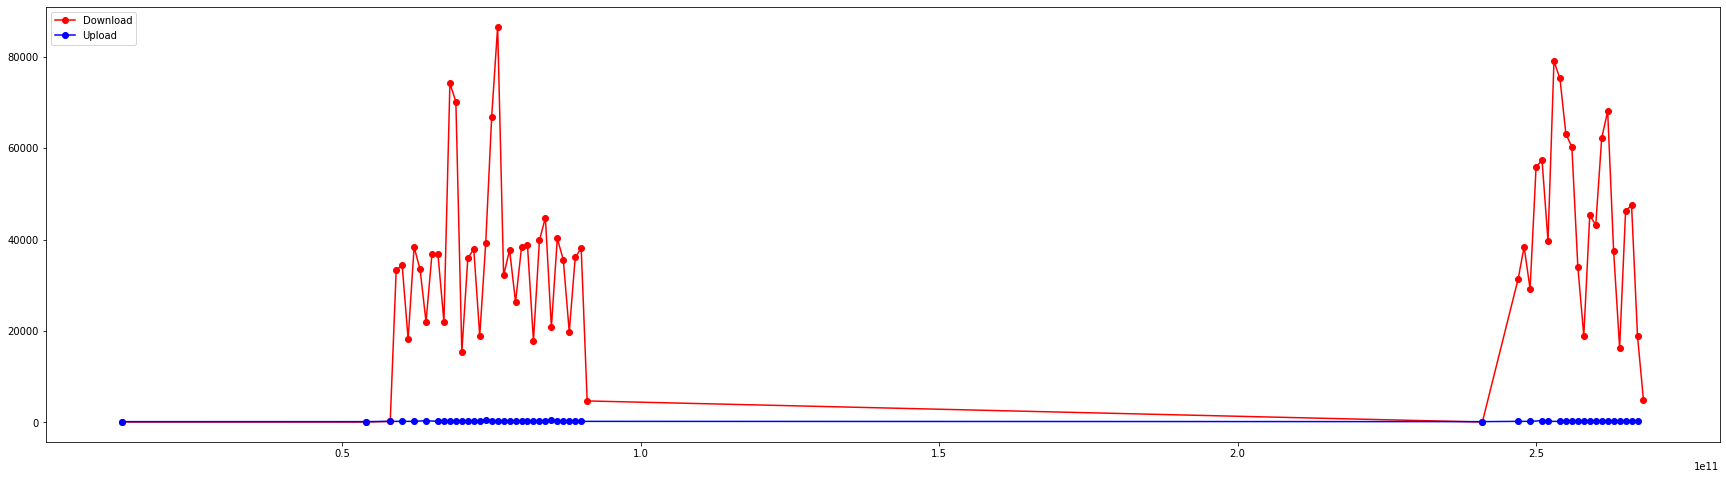

-- Connection 52.9.179.227 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 40716
 Device: Samsung Electronics Co.,Ltd
 City: San Jose
 ISP: Amazon.com
 LatLng: 37.3388 -121.8914


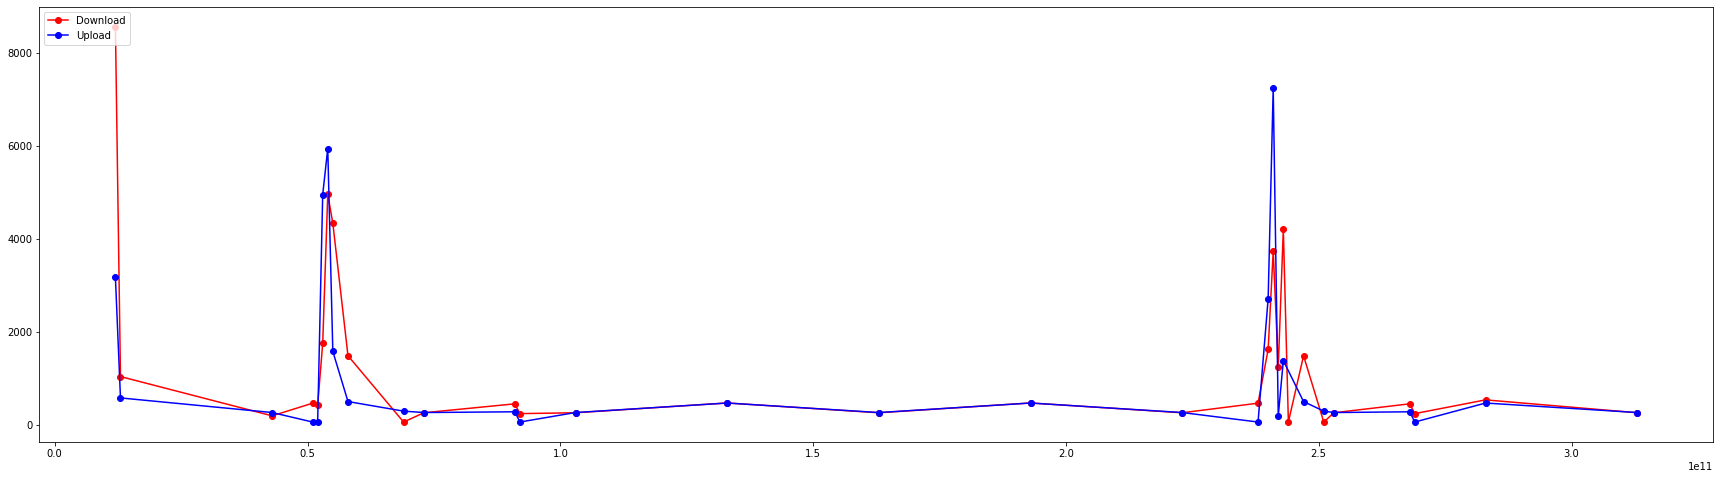

CONTINUE
CONTINUE
-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 224.0.0.251 01:00:5e:00:00:fb
 Total Bytes: 8892
 Device: Samsung Electronics Co.,Ltd
 City: 
 ISP: 
 LatLng: 0.0 0.0


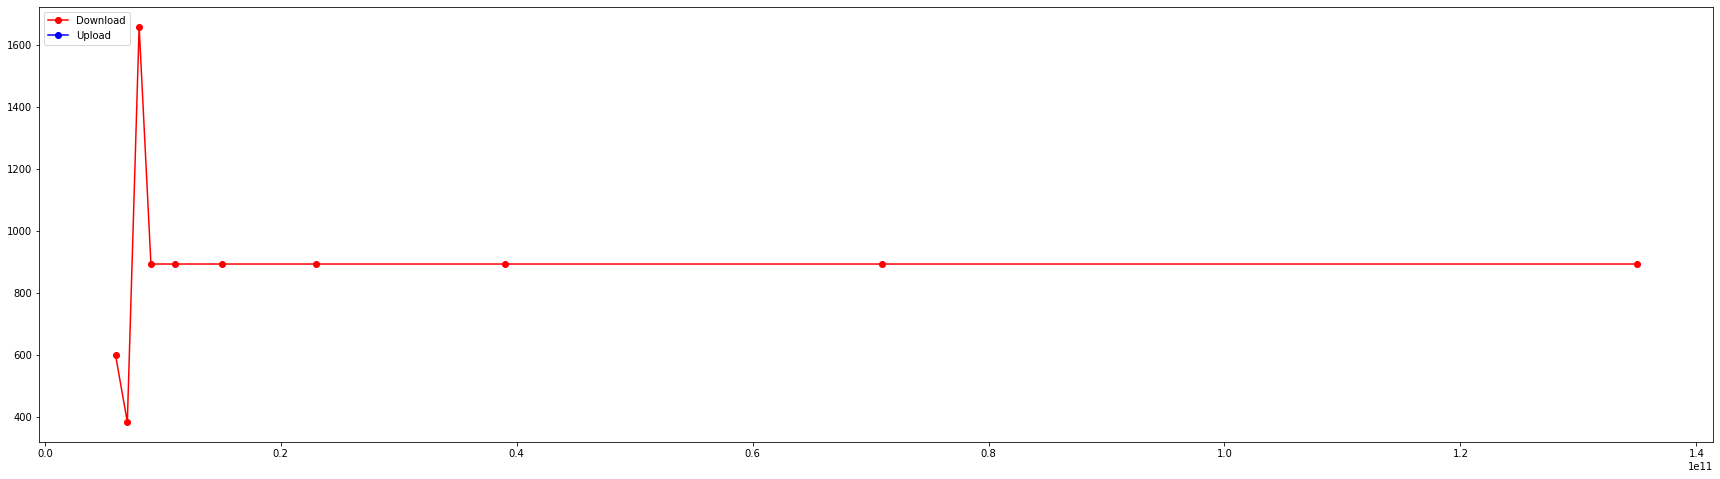

-- Connection 52.87.99.68 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 6042
 Device: Samsung Electronics Co.,Ltd
 City: Ashburn
 ISP: Amazon.com
 LatLng: 39.0481 -77.4728


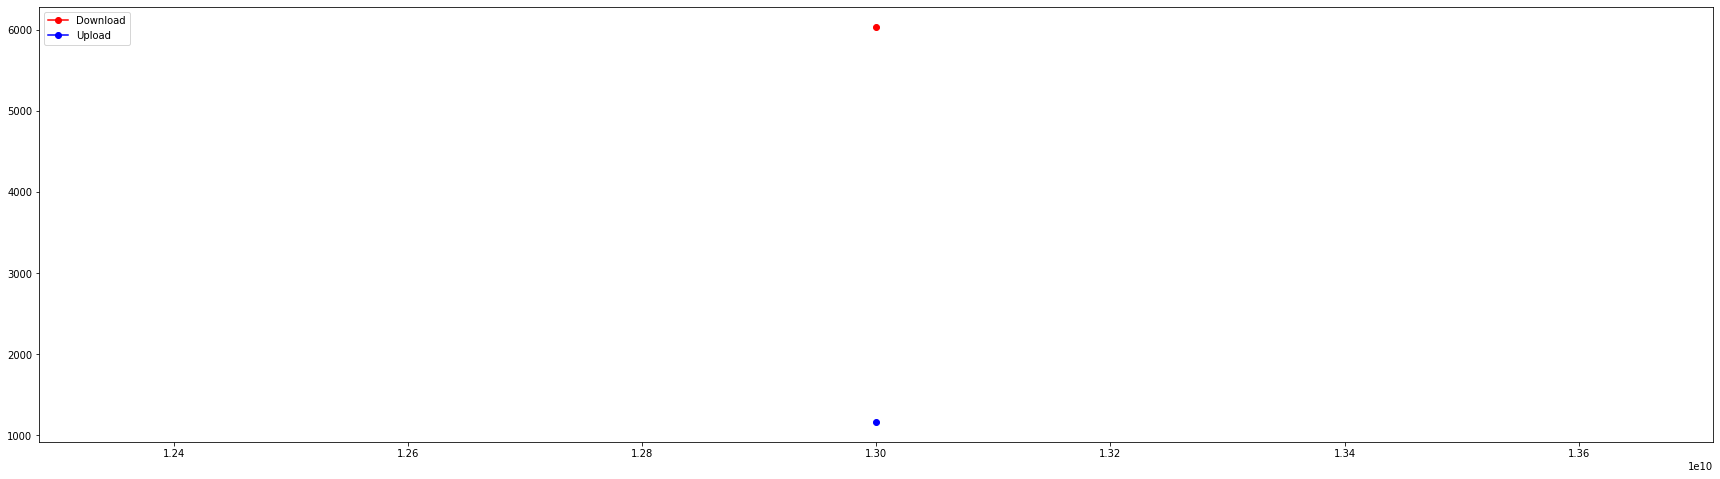

-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 128.135.11.14 dc:a6:32:37:d1:e2
 Total Bytes: 3724
 Device: Samsung Electronics Co.,Ltd
 City: Chicago
 ISP: University of Chicago
 LatLng: 41.7821 -87.6046


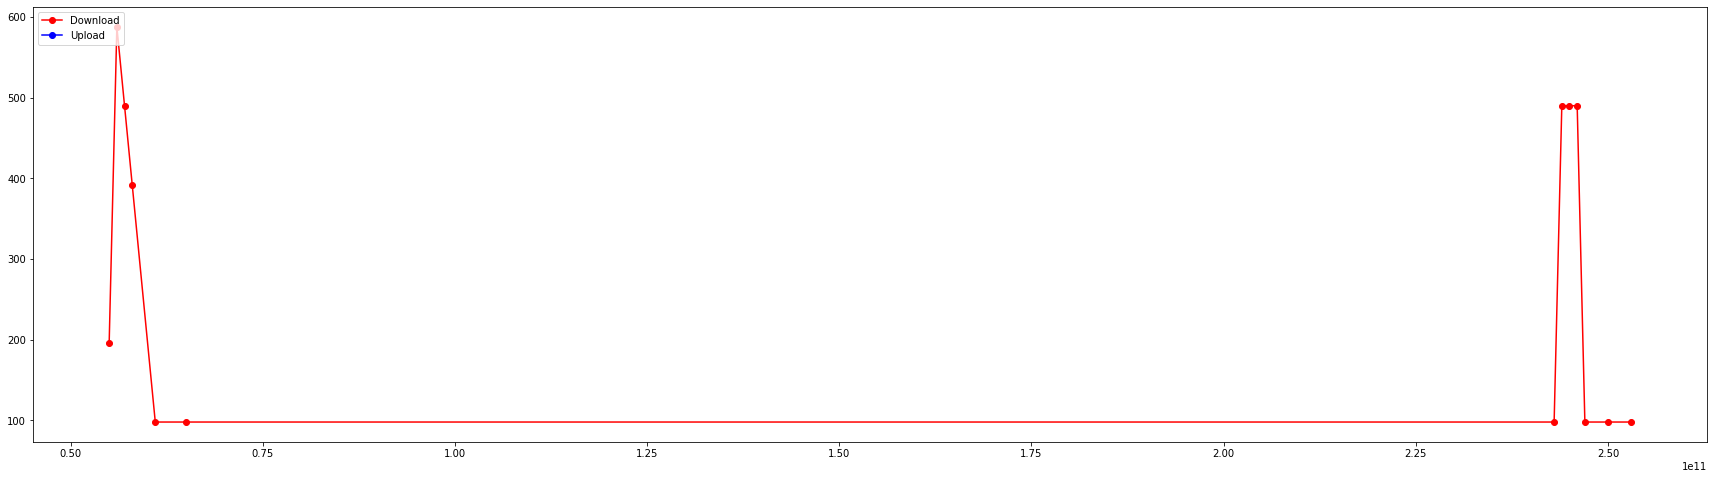

-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 192.168.143.58 dc:a6:32:37:d1:e2
 Total Bytes: 3724


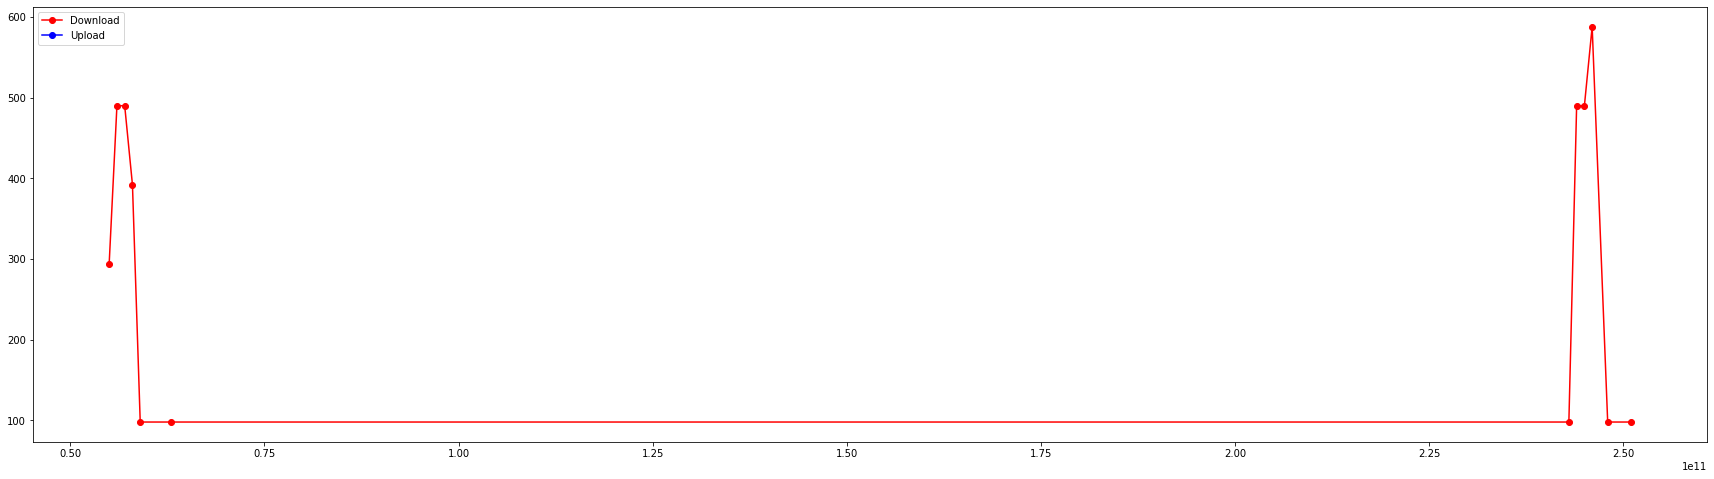

Exception:single positional indexer is out-of-bounds
-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 192.168.144.1 dc:a6:32:37:d1:e2
 Total Bytes: 2182


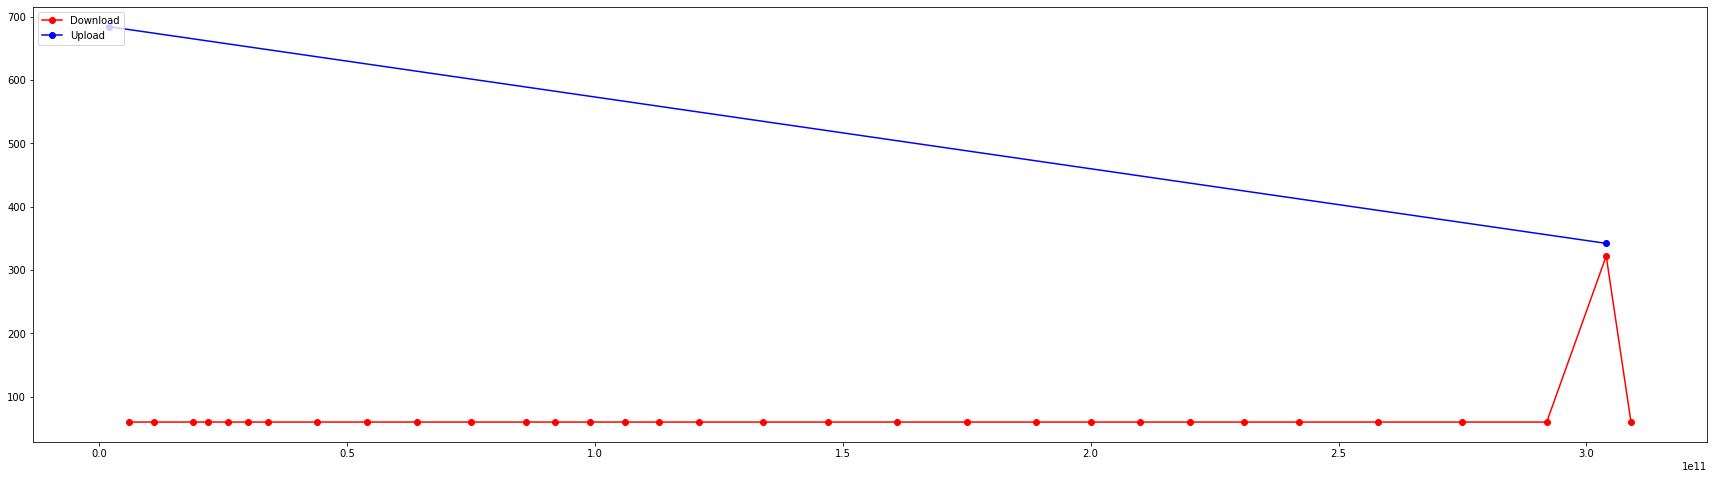

-- Connection 99.84.169.20 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 1955
 Device: Samsung Electronics Co.,Ltd
 City: Seattle
 ISP: Amazon CloudFront
 LatLng: 47.54 -122.3032


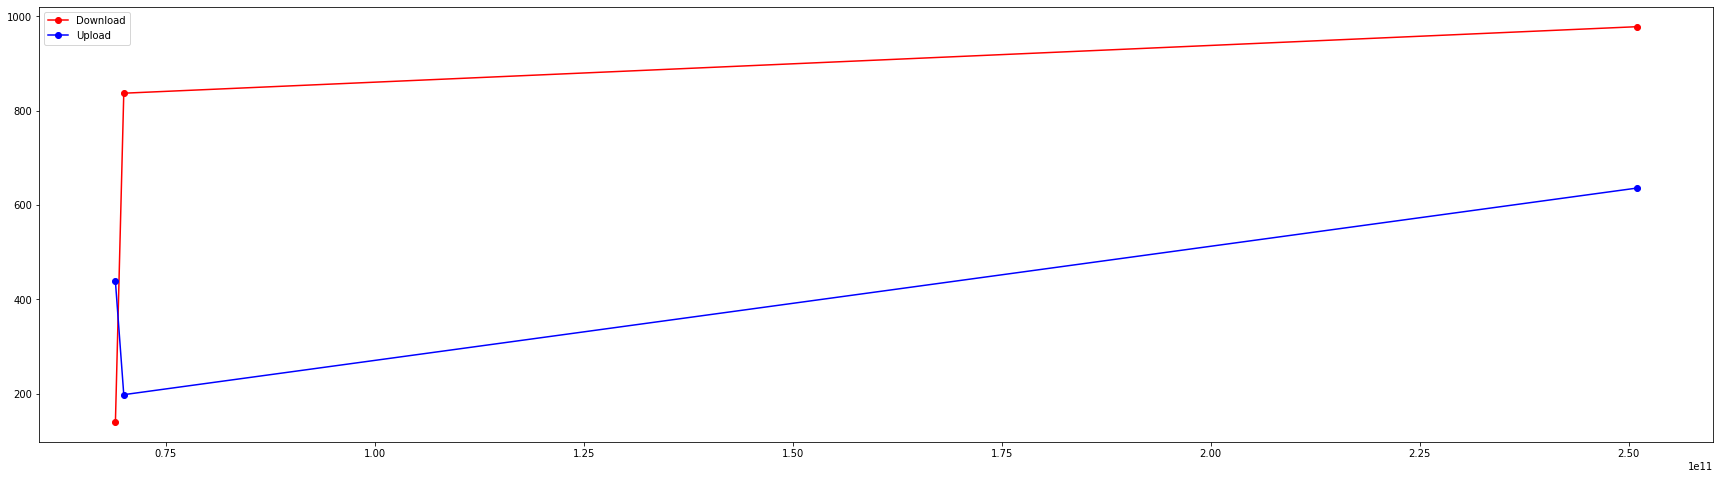

-- Connection 8.8.8.8 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 1825
 Device: Samsung Electronics Co.,Ltd
 City: Dallas
 ISP: Google
 LatLng: 32.7889 -96.8021


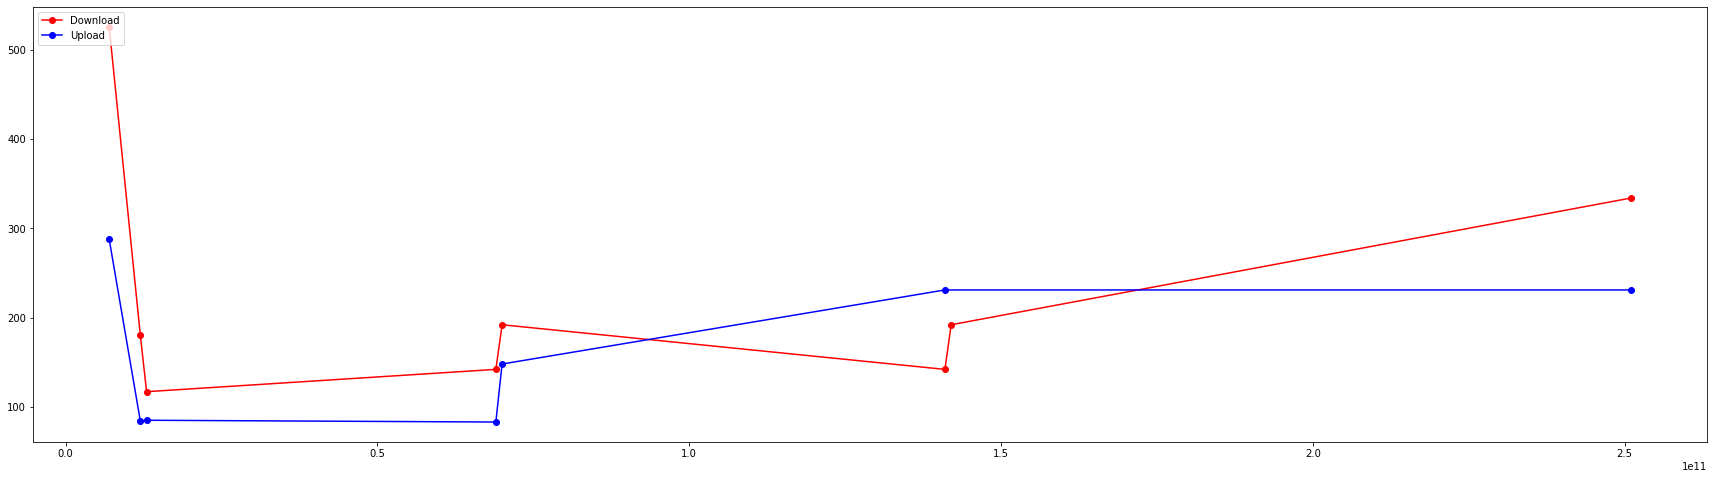

CONTINUE
CONTINUE
CONTINUE
CONTINUE
-- Connection 99.84.254.11 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 978
 Device: Samsung Electronics Co.,Ltd
 City: Seattle
 ISP: Amazon CloudFront
 LatLng: 47.54 -122.3032


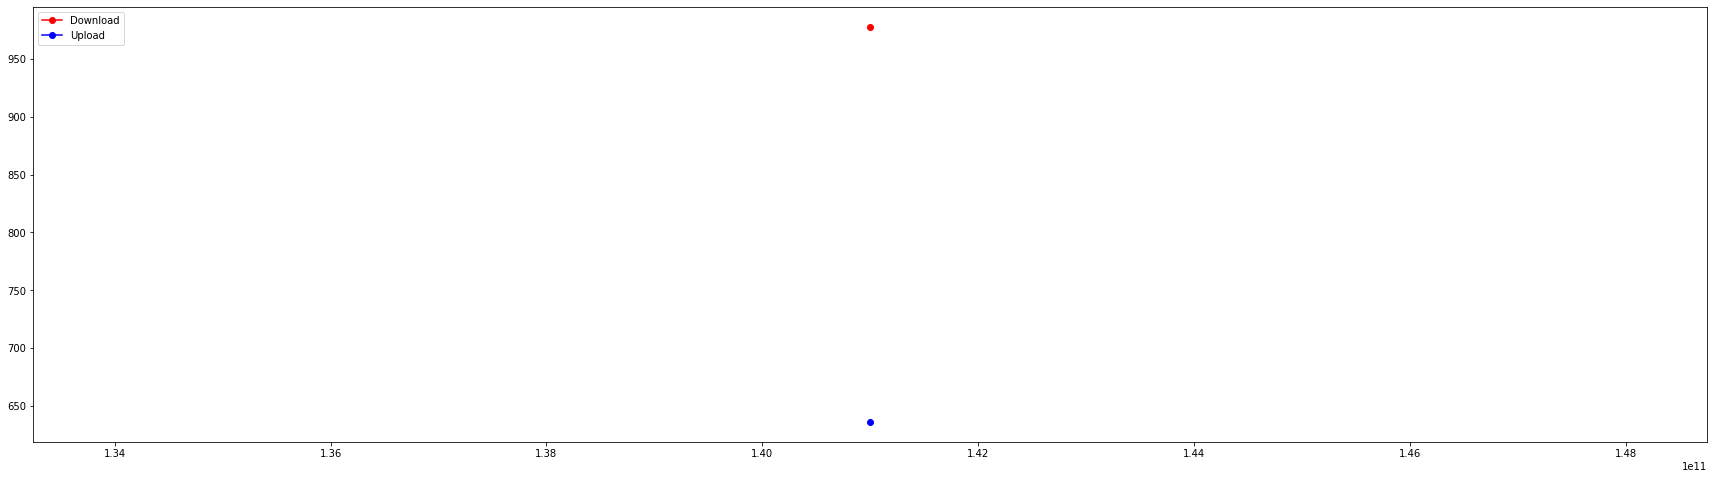

-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 172.253.112.109 dc:a6:32:37:d1:e2
 Total Bytes: 816
 Device: Samsung Electronics Co.,Ltd
 City: 
 ISP: Google
 LatLng: 37.751 -97.822


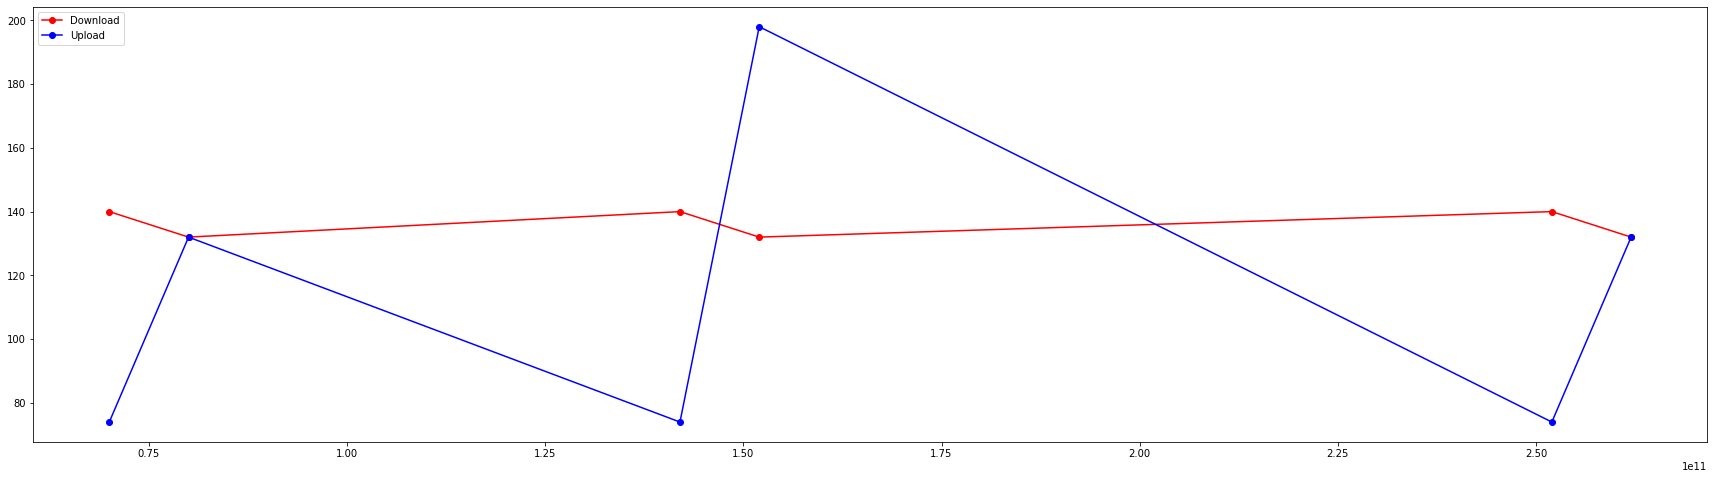

CONTINUE
Exception:single positional indexer is out-of-bounds
CONTINUE
-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 255.255.255.255 ff:ff:ff:ff:ff:ff
 Total Bytes: 304
-- Connection 192.168.144.25 00:16:6c:c2:38:2d <-> 224.0.0.22 01:00:5e:00:00:16
 Total Bytes: 244
-- Connection 208.75.88.4 dc:a6:32:37:d1:e2 <-> 192.168.144.25 00:16:6c:c2:38:2d
 Total Bytes: 90
CONTINUE


In [36]:
###
# For analyzing or processing network traffic, and precisely 
# look at the content of each TCP/UDP connection, we usually
# group packets by a 5-tuple unique identification of each connection.
# The 5-tuple contains ip.src, ip.dst, tcp.dstport, tcp.srcport and ip.proto.
# Here we'll use a simplified grouping of packets considering only
# ip src and dst addresses.

##
# Get the length in time_relative of the full pcap and create 1sec time bins
bins = list(range(0,int(np.ceil(dfpcap1['frame.time_relative'].max())+1)))
bins = [float(x) for x in bins]

labels = ['{}-{}'.format(i + 1, j) for i, j in zip(bins[:-1], bins[1:])]
labels

# Add delta
delta=[]
for index, row in dfpcap1.iterrows():
    delta.append(pd.to_timedelta(int(np.ceil(row['frame.time_relative'])), unit="s"))
dfpcap1['delta']=delta

# This is ascending the delta increase overtime
df_dw = dfpcap1.groupby(['ip.src', 'ip.dst',\
                         pd.Grouper(key='delta', freq='1s')])['frame.len'].sum()\
                         .reset_index().sort_values(by=['delta'], ascending=True)
df_up = dfpcap1.groupby(['ip.dst', 'ip.src',\
                         pd.Grouper(key='delta', freq='1s')])['frame.len'].sum()\
                         .reset_index().sort_values(by=['delta'], ascending=True)

df_conn=dfpcap1.groupby(['ip.src','ip.dst'])['frame.len'].sum()\
    .reset_index().rename(columns={'frame.len':'total_bytes'})\
    .sort_values(by=['total_bytes'], ascending=False)


print("INFO: Processing " + str(len(df_conn.index)) + "/2 connections.")

visited={}

for index, row in df_conn.iterrows():
    try: #TODO: better to use hash here
        if visited[row['ip.src']+"-"+row['ip.dst']]:
            print("CONTINUE")
            continue
    except KeyError as ke:
        pass
    
    # visit the reverse flow as it will be processed in both in one pass
    visited[row['ip.dst']+"-"+row['ip.src']] = True

    try:
        eth_src = ip_mac_map[ip_mac_map['ip.dst']==row['ip.src']]['eth.dst'].iloc[0]
        eth_dst = ip_mac_map[ip_mac_map['ip.dst']==row['ip.dst']]['eth.dst'].iloc[0]
    except Exception as e:
        #some frames don't have ip addresses (non-ip protocol packets)
        print("Exception:" + str(e))
        #pass
        continue
        
    print("-- Connection " + row['ip.src'] + " " + eth_src +
          " <-> "+ row['ip.dst'] + " " + eth_dst)
    print(" Total Bytes: " + str(row['total_bytes']))
 
    ###
    # we can suppress tiny size connections, 
    # but what if it's malware c&c packet?
    if row['total_bytes'] < 500:
        continue
    
    ##
    # The mac resolution and mapping can be found in both directions
    # The connection dataframe dosn't have complete information,
    # so one should fail.
    direction = ['ip.src', 'ip.dst']
    for dir in direction:
        try:
            print(" Device: " + connection[connection['ip.dst']==row[dir]]['ouiman'].iloc[0])
        except: pass

        try:
            print(" City: " + connection[connection['ip.dst']==row[dir]]['city'].iloc[0])
            print(" ISP: " + connection[connection['ip.dst']==row[dir]]['isp'].iloc[0])
            print(" LatLng: " + str(connection[connection['ip.dst']==row[dir]]['lat'].iloc[0])
                + " " + str(connection[connection['ip.dst']==row[dir]]['lng'].iloc[0]))
        except Exception as e:
            #print("FAILED for "+dir+" error:" +str(e))
            pass

    plt.figure(figsize=(30, 8))
    df_dw1=df_dw[(df_dw['ip.src']==row['ip.src']) & (df_dw['ip.dst']==row['ip.dst'])]
    df_up1=df_up[(df_up['ip.dst']==row['ip.src']) & (df_up['ip.src']==row['ip.dst'])]

    plt.plot(df_dw1['delta'], df_dw1['frame.len'], 'r-o', label = 'Download')
    plt.plot(df_up1['delta'], df_up1['frame.len'], 'b-o', label = 'Upload')

    plt.legend(loc="upper left")
    plt.show()
    
    # This is a 1-second aggregation of network traffic,
    # short connection < 1sec should appear in a single dot (1 for up, 1 for dw)


##### At this point you should be able to see a list of multiple time series line charts, this is the throughput over time for each connection
- this list is ordered by total data transfer of each connection;
- if you are processing camera4.pcap you'll see two big "moutains" that correlate to the activities described in the camera4.pcap.log file
- again the big question is: How can we flag data transfers that carry sensitive information or does not correlate to any activity?

In [37]:
# Exercises:
# 1.Use the Wireshark application to capture traffic with your
# Single Board Computer station or your own laptop.
# Access your favorite site via web browser while recording the pcap. 
# Try far distant sites like below, see if they are colocated: 
# https://www.tvnz.co.nz/
# https://www3.nhk.or.jp/
# 2. Save the pcap to a file and restart this notebook using the
# new pcap
# 3. Try switching the direction to download and see if the map
# changes. Use the variable ip_dir='ip.src' while creating the
# 'connection' dataframe
# 4. Try to aggregate all the traffic sent and received by the device. 
# 5. Implement real-time peak and/or valley detection algo of your choice.
# (This can help to filter TCP/UDP flows with large volumes of traffic,
# but probably not super helpful to detect low activity c&c communication.)
# Here are simple ones, lift from:
# https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/
# https://gist.github.com/sixtenbe/1178136


![simplepeakdetection](stackoverflow.Q22583391.gif "simplepeakdetection")

### 4. DPI (Deep Packet Inspection) Techniques

DPI techniques are on your side when it comes to IoT monitoring. Old-fashioned DPI only matches packet payloads with know protocol signatures and process "easy-to-read" features like the inter-arrival time of packets. Nowadays most of the traffic is encrypted and some protocols go beyond simple encryption by implementing obfuscation techniques to the various levels. Here we implement a few techniques to expose the anatomy of the IoT communication. The techniques described here require heavy packet processing and are not available even to the most powerful high-performance commercial DPI hardware. The general goal is to engineer key (virtual-)features to feed more advanced ML/anomaly detection techniques. Ideally, we want to make these techniques to run efficiently and to be operational to large scale monitoring groups such as SOCs (Security Operations Centers) and/or to home internet users.





In [55]:
payload_df1 = dfpcap1[dfpcap1['ip.proto']=='17']['tcp.payload'].dropna() #
payload_df1.head(20)
#tcp.payload[0:3] == 3c:73:74

Series([], Name: tcp.payload, dtype: object)

#### Below very basic examples of commands that can be used to investigate ip addresses.

In [ ]:
###
# Found an IP endpoint in Asia according to MaxMInd, 
# We can still dig in, get more info, wait,
# Google Cloud in Asia?? MaxMind, are you ok?
r = requests.request("GET", urljoin(iotlaburl+"/geoip/","35.201.123.184"))
r.json()

In [ ]:
##
# Dispite the bizarre Location MaxMind is right about ISP/CDN
!whois 35.201.123.184

In [ ]:
## 
# Latency isn't high (< 10ms), it shouldn't be too far, possibly colocated
!ping -c 5 35.201.123.184

In [ ]:
##
# Traceroute usually takes different path everytime you run,
# But it can be still used to reveal important information about
# intermediary hops
!traceroute 35.201.123.184

#traceroute to 35.201.123.184 (35.201.123.184), 64 hops max, 52 byte packets
#...
# 8  r-equinix-isp-ae2-2213.wiscnet.net (216.56.50.45)  4.567 ms  5.589 ms  4.622 ms
# 9  72.14.218.180 (72.14.218.180)  5.763 ms  4.679 ms  4.221 ms
#10  108.170.243.193 (108.170.243.193)  4.016 ms
#    108.170.243.225 (108.170.243.225)  6.219 ms
#    108.170.244.1 (108.170.244.1)  5.244 ms
#11  216.239.51.117 (216.239.51.117)  5.365 ms
#    72.14.232.153 (72.14.232.153)  4.855 ms  <--- intermediary hops can tell something
#    72.14.232.169 (72.14.232.169)  4.571 ms   <--- 
#12  184.123.201.35.bc.googleusercontent.com (35.201.123.184)  4.512 ms  5.164 ms  4.771 ms

In [ ]:
##
# IP in Australia, closer to Asia, also Google.
# Nothing to worry about
r = requests.request("GET", urljoin(iotlaburl+"/geoip/","72.14.232.169"))
r.json()